In [22]:
import pandas as pd

In [59]:
pd.__version__

'2.2.3'

In [93]:
def read_dataframe(df):
    
    df = df.sample(n=300000, random_state=1)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    negative_durations = df[df['duration'] < 0]

    df = df[df['duration'] >= 0]

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [94]:
train = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet')

In [95]:
validation = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-02.parquet')

In [96]:
train_df = read_dataframe(train)

In [97]:
train_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'duration'],
      dtype='object')

In [98]:
val_df = read_dataframe(validation)

In [99]:
(len(train_df),len(val_df))

(294173, 293354)

In [100]:
train_df['PU_DO'] = train_df['PULocationID'] + '_' + train_df['DOLocationID']
val_df['PU_DO'] = val_df['PULocationID'] + '_' + val_df['DOLocationID']

In [101]:
categorical = ['PU_DO']
numerical = ['fare_amount','total_amount','trip_distance']


In [29]:
# correlation_matrix = df[numerical].corr()

# # Plotting the correlation heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(df[['duration']], annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
# plt.title('Correlation between Duration and Other Numerical Features')
# plt.show()


In [102]:
from sklearn.feature_extraction import DictVectorizer

In [103]:
dv = DictVectorizer()

train_dicts = train_df[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = val_df[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [104]:
target = 'duration'
y_train = train_df[target].values
y_val = val_df[target].values

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [106]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

np.float64(4.352449832199674)

Text(0, 0.5, 'Density')

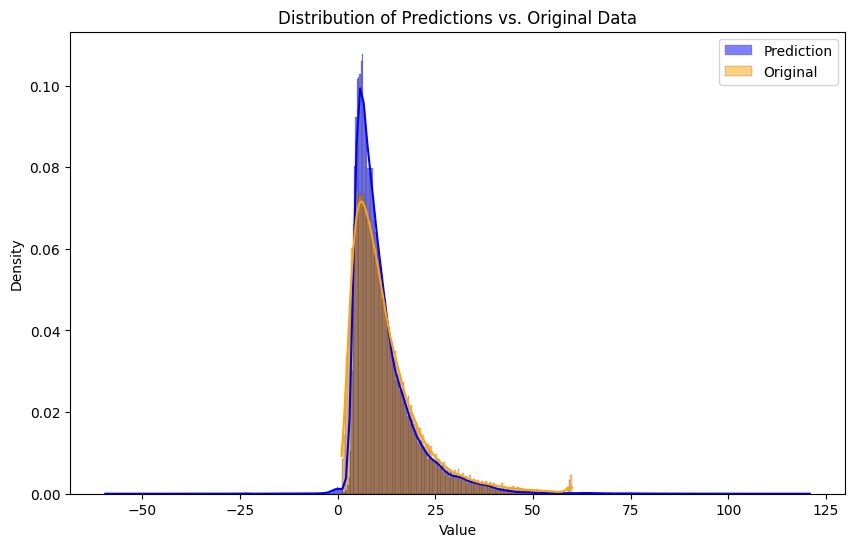

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plotting predictions
sns.histplot(y_pred[:100000], color='blue', label='Prediction', kde=True, stat='density', alpha=0.5)

# Plotting original data
sns.histplot(y_val[:100000], color='orange', label='Original', kde=True, stat='density', alpha=0.5)

# Adding legend and labels
plt.legend()
plt.title('Distribution of Predictions vs. Original Data')
plt.xlabel('Value')
plt.ylabel('Density')

In [110]:
import pickle
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,lr),f_out)